In [7]:
import requests, sys, os, shutil, re, threading
from bs4 import BeautifulSoup as bs

In [54]:
import requests
from bs4 import BeautifulSoup

def download_cat_images():
    url = 'https://www.pinterest.com/search/pins/?q=baby%20cat&rs=typed'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    img_tags = soup.find_all('img')
    urls = [img['src'] for img in img_tags]
    print(urls)
    #for url in urls:
        #response = requests.get(url)

In [15]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

#  Any infinity scroll URL
var = "art"
url = "https://in.pinterest.com/search/pins/?q=" + var 
ScrollNumber = 500  # The depth we wish to load
sleepTimer = 1    # Waiting 1 second for page to load

#  Bluetooth bug circumnavigate
options = webdriver.ChromeOptions() 
options.add_experimental_option("excludeSwitches", ["enable-logging"])

driver = webdriver.Chrome(options=options)  # path=r'to/chromedriver.exe'
driver.get(url)
everything_list = []
for _ in tqdm(range(1,ScrollNumber)):
    driver.execute_script("window.scrollTo(1,100000)")
    time.sleep(sleepTimer)

    soup = BeautifulSoup(driver.page_source,'html.parser')

    for link in soup.find_all('img'):
        everything_list.append(link.get('src'))

100%|██████████| 499/499 [09:00<00:00,  1.08s/it]


In [16]:
len(set(everything_list))

554

In [ ]:
for url in tqdm(set(everything_list)):
    response = requests.get(url)
    with open(f'Other/{url.split("/")[-1]}', 'wb') as f:
        f.write(response.content)

 55%|█████▍    | 303/554 [00:17<00:13, 18.22it/s]

In [111]:
import os
import shutil
cur_dir = '../../../Downloads/cats/'
out_dir = 'cats/'
for elem in os.listdir(cur_dir)[1:]:
    cur_path = os.path.join(cur_dir, elem)
    cur_amount = os.listdir(cur_path)
    for elem2 in cur_amount:
        cur_path2 = os.path.join(cur_path, elem2)
        if cur_path2[-3:] == 'cat':
            continue
        shutil.copyfile(cur_path2, os.path.join(out_dir, elem2))

In [9]:
import os
import shutil

all_cats = set(os.listdir('cats'))
all_adults = set(os.listdir('cats2'))
all_babies = all_cats.difference(all_adults)

In [14]:
for elem in all_babies:
    shutil.copyfile(os.path.join('cats', elem) , os.path.join('babycats2', elem))

In [3]:
import os
import shutil
imgs = []
labels = []
for elem in os.listdir('adults'):
    cur_path = os.path.join('adults', elem)
    imgs.append(cur_path)
    labels.append(0)
for elem in os.listdir('kittens'):
    cur_path = os.path.join('kittens', elem)
    imgs.append(cur_path)
    labels.append(1)
for elem in os.listdir('Other'):
    cur_path = os.path.join('Other', elem)
    imgs.append(cur_path)
    labels.append(2)


    


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
d = {'path': imgs, 'label': labels}
df = pd.DataFrame(data=d)
train, val = train_test_split(df, test_size=0.2)
train = train.reset_index()
val = val.reset_index()

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.img_paths = df['path']
        self.labels = df['label']
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform[self.split](image)    
        return image, label
    
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
train_dataset = CustomImageDataset(train, 'train', transform=data_transforms)
val_dataset = CustomImageDataset(val, 'val', transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [8]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [98]:
number_of_epochs = 50
for epoch in range(number_of_epochs):
    print('Epoch {}/{}'.format(epoch, number_of_epochs - 1))
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 0/49


  1%|▎                                        | 1/136 [01:07<2:31:29, 67.33s/it]


KeyboardInterrupt: 

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
params = torch.load('tensor_final.pt', map_location=torch.device('cpu'))
model.load_state_dict(params)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
transform = transforms.Compose([
    transforms.Resize(256),  # or whatever size you trained on
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [41]:
def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image_orig = image
    image = transform(image).float()
    image = image.unsqueeze(0)
    return image, image_orig
import matplotlib.pyplot as plt

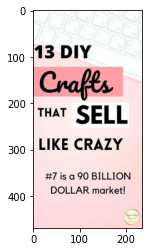

In [42]:
img_path = "Other/0c264b442824226c5572623df1314ffa.jpg"
image, image_orig = image_loader(img_path)  # your image path
plt.imshow(image_orig)

In [56]:
with torch.no_grad():
    prediction = model(image)
    prediction = prediction.argmax(dim=1)
    if prediction == 1:
        print('Kitten')
    elif prediction == 2:
        print('Other')
    else:
        print('Adult Cat')

Other


In [63]:
incorrects = []
for elem in tqdm(os.listdir('kittens')):
    cur_path = os.path.join('kittens', elem)
    try:
        image, image_orig = image_loader(cur_path) 
    except:
        continue
    with torch.no_grad():
        prediction = model(image)
        prediction = prediction.argmax(dim=1)
        if prediction.numpy()[0] != 1:
            incorrects.append((image, image_orig))

100%|█████████████████████████████████████████| 1345/1345 [03:42<00:00,  6.06it/s]


In [64]:
len(incorrects)

122

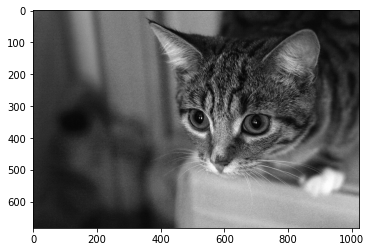

In [82]:
cur = incorrects[30]
plt.imshow(cur[1])